In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime, timedelta

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [2]:
# dates=["Jan 22","Jan 23","Jan 24","Jan 25","Jan 26","Jan 27","Jan 28","Jan 29","Jan 30","Jan 31","Feb 01","Feb 02","Feb 03","Feb 04","Feb 05","Feb 06","Feb 07","Feb 08","Feb 09","Feb 10","Feb 11","Feb 12","Feb 13","Feb 14","Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05"]
dates=[]
for result in perdelta(date(2020, 1, 22), date(2020, 5, 6), timedelta(days=1)):
     dates.append(result)
deaths=[0,8,16,15,24,26,26,38,43,46,45,58,64,66,73,73,86,89,97,108,97,146,122,143,143,106,98,136,117,121,113,100,158,81,64,37,58,65,54,73,67,85,83,102,106,105,228,197,274,330,353,447,414,691,648,820,983,1094,1380,1644,1638,1932,2486,2589,2945,3469,3671,3343,4160,4709,5190,6270,5962,6066,5004,5606,7892,6735,7666,7347,6208,5565,5639,7408,8190,6998,8429,6676,4894,5489,7284,6698,6705,6417,6101,3757,4509,6688,6593,5795,5623,5217,3480,4096,5786]
df=pd.DataFrame(deaths,dates)
df.columns=['deaths']
df

,deaths
2020-01-22,0
2020-01-23,8
2020-01-24,16
2020-01-25,15
2020-01-26,24
...,...
2020-05-01,5623
2020-05-02,5217
2020-05-03,3480
2020-05-04,4096


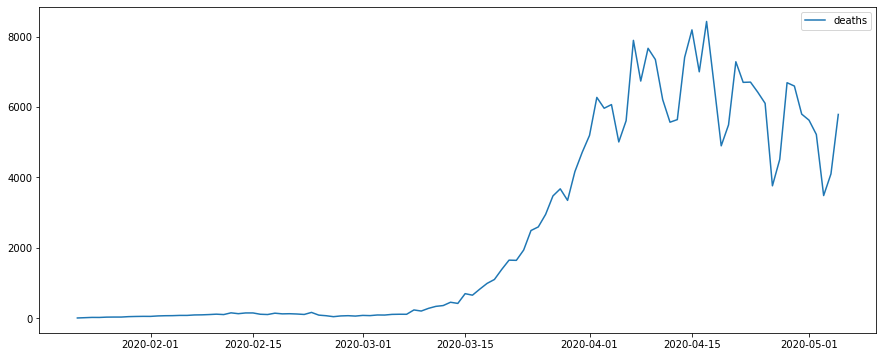

In [3]:
df.plot(figsize=(15,6))

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
deaths,105.0,2457.228571,2834.696939,0.0,86.0,447.0,5489.0,8429.0


In [5]:
df['Deaths First Difference'] = df['deaths'] - df['deaths'].shift(1)

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
result = adfuller(df['deaths'])

In [8]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_check(df['Deaths First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3610160111232095
p-value : 0.6008163662359767
#Lags Used : 9
Number of Observations Used : 94
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


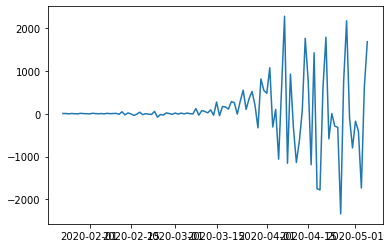

In [10]:
df['Deaths First Difference'].plot()

In [11]:
df['Deaths Second Difference'] = df['Deaths First Difference'] - df['Deaths First Difference'].shift(1)

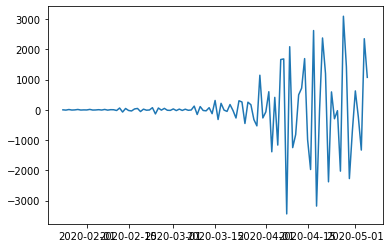

In [12]:
df['Deaths Second Difference'].plot()

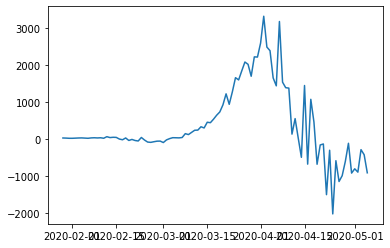

In [13]:
df['Seasonal Difference'] = df['deaths'] - df['deaths'].shift(7)
df['Seasonal Difference'].plot()

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(df['deaths'],order=(0,1,0), seasonal_order=(1,1,1,7))
results = model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                              deaths   No. Observations:                  105
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood                -746.127
Date:                             Thu, 07 May 2020   AIC                           1498.253
Time:                                     04:57:41   BIC                           1505.978
Sample:                                 01-22-2020   HQIC                          1501.377
                                      - 05-05-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1476      0.176     -0.837      0.403      -0.493       0.198
ma.S.L7       -0.3650      

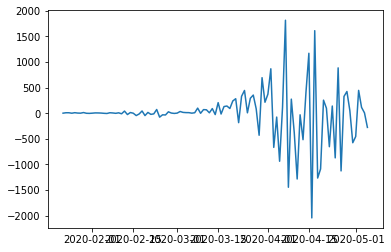

In [16]:
results.resid.plot()

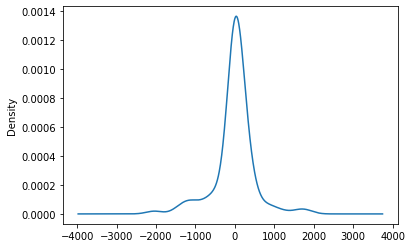

In [17]:
results.resid.plot(kind='kde')

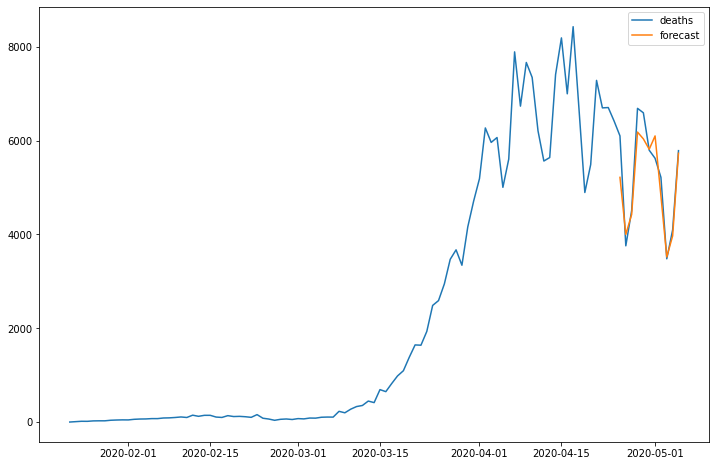

In [18]:
df['forecast'] = results.predict(start = 94, end= 104, dynamic= True)  
df[['deaths','forecast']].plot(figsize=(12,8))

In [19]:
df.tail()

,deaths,Deaths First Difference,Deaths Second Difference,Seasonal Difference,forecast
2020-05-01,5623,-172.0,626.0,-794.0,6100.220994
2020-05-02,5217,-406.0,-234.0,-884.0,4818.470248
2020-05-03,3480,-1737.0,-1331.0,-277.0,3518.495604
2020-05-04,4096,616.0,2353.0,-413.0,3968.894723
2020-05-05,5786,1690.0,1074.0,-902.0,5730.700178


In [25]:
from pandas.tseries.offsets import DateOffset

In [67]:
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,27) ]

In [68]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [69]:
future_df = pd.concat([df,future_dates_df])

In [70]:
future_df.head()

,deaths,Deaths First Difference,Deaths Second Difference,Seasonal Difference,forecast
2020-01-22,0,NaN,NaN,NaN,NaN
2020-01-23,8,8.0,NaN,NaN,NaN
2020-01-24,16,8.0,0.0,NaN,NaN
2020-01-25,15,-1.0,-9.0,NaN,NaN
2020-01-26,24,9.0,10.0,NaN,NaN


In [71]:
future_df.tail(9)

,deaths,Deaths First Difference,Deaths Second Difference,Seasonal Difference,forecast
2020-05-23 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-24 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-25 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-26 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-28 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-30 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN


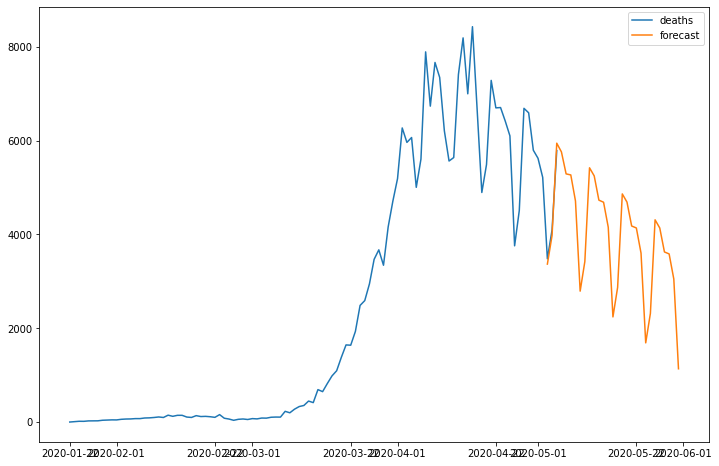

In [72]:
future_df['forecast'] = results.predict(start = 102, end = 160, dynamic= True)  

future_df[['deaths', 'forecast']].plot(figsize=(12, 8))


In [79]:
future_df['forecast'].tail(25)

2020-05-07    5290.755311
2020-05-08    5268.160745
2020-05-09    4713.123091
2020-05-10    2790.577482
2020-05-11    3421.211660
2020-05-12    5420.327591
2020-05-13    5247.993939
2020-05-14    4730.826562
2020-05-15    4686.179771
2020-05-16    4153.140058
2020-05-17    2241.366021
2020-05-18    2868.898320
2020-05-19    4863.416756
2020-05-20    4689.106603
2020-05-21    4179.116774
2020-05-22    4137.724889
2020-05-23    3601.438282
2020-05-24    1688.074363
2020-05-25    2316.064498
2020-05-26    4311.261524
2020-05-27    4137.243102
2020-05-28    3626.193868
2020-05-29    3584.321559
2020-05-30    3048.514193
2020-05-31    1135.384941
Name: forecast, dtype: float64

In [ ]:
96,150 more deaths by the end of the month